* 아래 함수는 `weather_localcenter_metadata`와 `weather_5minute_ASOS_2020-2023.parquet`, `holiday.csv`를 사용하여 5분 단위 기상대표값을 도출합니다.
* 본 모델링에서는 기상인자로 최고기온, 최저기온, 평균일사량 데이터를 사용하고자 합니다. 일사량의 결측치 비율을 최소화 하기 위해 울산시를 제외한 특별시 및 광역시 데이터를 사용하였으며 (울산시 일사량 데이터의 대부분이 결측치였음), 강원도의 기상 인자도 반영하기 위해 도내에서 가장 인구가 많은 도시인 원주를 포함하였습니다.
* 보간법을 적용하기 전의 기온과 일사량의 결측치 비율은 전체 대비 0.2%, 0.4% 수준이며, 선형보간법을 통해 결측치를 보완하고자 했습니다.
* 단순히 휴일여부가 아니라 어떤 휴일에 해당하는지를 더미변수로 추가해보았습니다. (휴일이 아닌 날, 신정, 설날, 삼일절, 선거일, 어린이날, 석가탄신일, 현충일, 광복절, 추석, 개천절, 기독탄신일, 한글날, 대체공휴일 등 총 14가지로 분류)

In [2]:
def weather_data_5minute(weather_metadata_path, weather_5minute_ASOS_path, holiday_path):

  import pandas as pd

  # 기상관측 MetaData 불러오기
  weather_metadata = pd.read_csv(weather_metadata_path)
  STN_dict = {STN_name : STN_num for STN_num, STN_name in zip(weather_metadata['지점'], weather_metadata['지점명'])}
  target_STN_list = [STN_dict[STN_name] for STN_name in ['서울', '부산', '인천', '대구', '대전', '광주', '원주']]

  # 서울 포함 7개 도시의 기온 및 일사량 데이터 불러오기
  weather_5minute = pd.read_parquet(weather_5minute_ASOS_path).astype({'지점' : 'int'})
  weather_5minute = weather_5minute[weather_5minute['지점'].isin(target_STN_list)]
  weather_5minute = weather_5minute[['지점', '일시', '기온(°C)', '일사(MJ/m^2)']]
  weather_5minute.columns = ['지점', '일시', '기온', '일사']

  column_list = ['기온', '일사']

  # 선형보간법 사용하여 결측값 채우기
  for idx, STN in enumerate(target_STN_list):

      # ① 각 STN별로 데이터 나누기
      tmp = weather_5minute[weather_5minute['지점'] == STN]

      # ② 시간순으로 정렬하기
      tmp = tmp.sort_values(by='일시')

      # ③ 선형보간법을 사용하여 nan값 채우기                
      for column in column_list:
        tmp[column] = tmp[column].interpolate(method='linear')

      # ④ tmp 합치기
      if idx == 0:
        interpolated_weather = tmp
      else:
        interpolated_weather = pd.concat([interpolated_weather, tmp])

  # 전국 기상 대표값 정하기 (최고기온, 최저기온, 평균일사량)
  for idx, column in enumerate(column_list):
    if column == '기온':
      # 최고 기온
      tmp_1 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].max()).rename(columns = {'기온' : 'max_temp'})
      # 최저 기온
      tmp_2 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].min()).rename(columns = {'기온' : 'min_temp'})
      tmp = pd.merge(tmp_1, tmp_2, on = '일시', how = 'inner')
    else:
      # 평균 일사량
      tmp = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].mean()).rename(columns = {'일사' : 'mean_insolation'})
    # ② groupby 결과를 인덱스 기준으로 Join
    if idx == 0:
      representative_weather = tmp
    else:
      representative_weather = pd.merge(representative_weather, tmp, on = '일시', how = 'inner')

  representative_weather.rename(columns = {'일시' : 'datetime'}, inplace= True)

  # 요일 특성 반영 (더미변수로 반영)
  # 0 : 월요일, 1 : 화요일 ~ 금요일, 2 : 토요일, 3 : 일요일

  representative_weather['weekday'] = pd.to_datetime(representative_weather['datetime']).dt.weekday
  representative_weather.replace({'weekday' : {2 : 1, 3 : 1, 4 : 1, 5 : 2, 6 : 3}}, inplace = True)
  representative_weather = pd.get_dummies(representative_weather, columns = ['weekday'])
                                          
  # 휴일 유형에 맞춘 더미변수 반영

  holiday = pd.read_csv(holiday_path)

  for dateName in ['국회의원선거일', '대통령선거일', '동시지방선거일', '전국동시지방선거', '제21대 국회의원선거']:
    holiday.replace({'dateName' : {dateName : '선거일'}}, inplace = True)
  holiday.replace({'dateName' : {'1월1일' : '신정'}}, inplace = True)
  holiday.replace({'dateName' : {'부처님오신날' : '석가탄신일'}}, inplace = True)
  holiday.replace({'dateName' : {'어린이 날' : '어린이날'}}, inplace = True)
  holiday.replace({'dateName' : {'대체휴무일' : '대체공휴일'}}, inplace = True)
  holiday.replace({'dateName' : {'임시공휴일' : '대체공휴일'}}, inplace = True)

  nameToNumber = {dateName : idx + 1  for idx, dateName in enumerate(list(holiday['dateName'].unique()))}
  holiday.replace({'dateName' : nameToNumber}, inplace = True)
  holiday_dict = {locdate : dateName for dateName, locdate in zip(holiday['dateName'], holiday['locdate'])}

  for row_number in range(representative_weather.shape[0]):
    if representative_weather.at[row_number, 'datetime'][:-6] in list(holiday['locdate']):
      representative_weather.at[row_number, 'holiday'] = holiday_dict[representative_weather.at[row_number, 'datetime'][:-6]]
    else:
      representative_weather.at[row_number, 'holiday'] = 0

  representative_weather = pd.get_dummies(representative_weather, columns = ['holiday'])

  # 월, 시간 정보 반영 (더미변수로 반영)

  representative_weather['month'] = pd.to_datetime(representative_weather['datetime']).dt.month
  representative_weather = pd.get_dummies(representative_weather, columns = ['month'])
  representative_weather['hour'] = pd.to_datetime(representative_weather['datetime']).dt.hour
  representative_weather = pd.get_dummies(representative_weather, columns = ['hour'])

  return representative_weather

In [5]:
# 기상대표값 데이터 생성하기

weather_metadata_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/weather_localcenter_metadata.csv'
weather_5minute_ASOS_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/ASOS (2020-2023)/weather_5minute_ASOS_2020-2023.parquet'
holiday_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/time/holidays.csv'
representative_weather = weather_data_5minute(weather_metadata_path, weather_5minute_ASOS_path, holiday_path)

전력 데이터는 지호님이 완성해주신 `power_demand_interpolated`를 사용하였습니다.

In [6]:
# 전력 데이터 불러오기

import pandas as pd

power = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/load_supply/power_demand_interpolated.csv')
power.columns = ['datetime', 'load']

기상인자 대표값과 보간 처리된 전력데이터를 일시를 기준으로 Inner Join합니다.

In [7]:
# 전력 데이터와 기상인자 데이터 합치기
# 2023년 3월 19일까지의 데이터로 한정

target_df = pd.merge(representative_weather, power, on = 'datetime', how = 'inner')[:-288]

Custom Dataset과 Dataloader를 사용하여 메모리 사용량을 줄였습니다.

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.fit_transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1],
                                                               pd.DataFrame(scaler_for_Y.fit_transform(np.array(target_df['load']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = (self.dataset_tensor.shape[0] - step_len - seq_len) // stride
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride
  
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :], self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

# Scaler 객체 생성
ss_1 = MinMaxScaler() # Scaler for X
ss_2 = MinMaxScaler() # Scaler for y

# CustomDataset 파라미터 설정 (Scaler 객체, 시퀀스의 길이, 스텝 사이즈, 건너뛸 간격)
seq_len = 2016 # 시퀀스의 길이
step_len = 72 # 스텝 사이즈 (추정하고자 하는 값의 개수)
stride = 1 # 건너뛸 간격

# target_df를 train_df와 test_df로 분리
# target_df는 예측 대상 기간인 2023년 3월 13일부터 19일 + Sequence의 길이만큼의 데이터를 담음
test_df = target_df.iloc[-1 * (seq_len + 2016):,:]
train_df = target_df.iloc[:-1 * (seq_len + 2016),:]

# 데이터셋 생성
train_dataset = CustomDataset(train_df, 4, ss_1, ss_2, seq_len, step_len, stride)

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle = True, drop_last = True)

In [9]:
import torch.nn as nn

# 양방향 LSTM 모델 구성하기

input_dim = 58 # 입력 컬럼의 개수
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 72 # 출력 값의 개수(형태)
learning_rate = 0.0001 # 학습률
nb_epochs = 50 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)

class Net(nn.Module):
  def __init__(self, input_dim, hidden_dim, seq_len, out_dim, layers):
    super(Net, self).__init__()
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True, bidirectional = True)
    self.fc = nn.Linear(hidden_dim * 2, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
    )
  
  def forward(self, x):
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

In [10]:
import torch.nn as nn

# CNN + 양방향 LSTM 모델 구성하기

in_channels = 58 # 입력 컬럼의 개수
out_channels = 116 # 합성곱 필터로 생성될 out의 Dimension = 필터의 개수
kernel_size = 3 # 합성곱 필터의 kernel_size
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 72 # 출력 값의 개수(형태)
learning_rate = 0.0001 # 학습률
nb_epochs = 30 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)

class CNN_BILSTM(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):
    super(CNN_BILSTM, self).__init__()
    # 입력인자 정의
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    # 합성곱 Layer 정의
    self.conv1d = nn.Conv1d(in_channels = self.in_channels, 
                            out_channels = self.out_channels,
                            kernel_size = self.kernel_size, 
                            padding = 'same')
    # LSTM Layer 정의
    self.lstm = nn.LSTM(self.out_channels, 
                        self.hidden_dim, 
                        num_layers = self.layers, 
                        batch_first = True, 
                        bidirectional = True)
    # 완전연결층 정의
    self.fc = nn.Linear(hidden_dim * 2, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
  
  # 결과값 계산
  def forward(self, x):
    x = torch.transpose(x, 1, 2)
    x = self.conv1d(x)
    x = torch.transpose(x, 1, 2)
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

In [11]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 16.8 MB/s eta 0:00:00


In [13]:
cnn_bilstm_model = torch.load('/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/modeling/모델링 결과/model_20230526_CNN-BILSTM.pth')

In [12]:
# 모델 학습 함수 만들기

# !pip install torchmetrics
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from torchmetrics import MeanAbsolutePercentageError

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  nb_epochs = num_epochs
  mean_abs_percentage_error = MeanAbsolutePercentageError().to(device)

  # epoch마다 loss 저장
  train_hist = np.zeros(nb_epochs)
  output = []
  
  for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(train_df)
    for batch_idx, samples in enumerate(train_df):
      x_train, y_train = samples
      # seq별 hidden state reset
      model.reset_hidden_state()
      # H(x) 계산
      outputs = model(x_train)
      # cost 계산
      loss = mean_abs_percentage_error(outputs, y_train)
      # cost로 H(x) 개선
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_cost += loss/total_batch 

    train_hist[epoch] = avg_cost

    if epoch % verbose == 0:
      print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
    # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print('\n Early Stopping')
        break
  
  return model.eval(), train_hist

In [ ]:
# 양방향 LSTM 모델 학습 (Bidirectional LSTM layer를 2개로 설정하였습니다.)

net = Net(input_dim, hidden_dim, seq_length, output_dim, 2).to(device)
model, train_hist = train_model(net, train_dataloader, num_epochs = nb_epochs,
                                lr = learning_rate, verbose = 1, patience = 4)

Epoch: 0000 train loss : 0.2465
Epoch: 0001 train loss : 0.1671
Epoch: 0002 train loss : 0.1260
Epoch: 0003 train loss : 0.1186
Epoch: 0004 train loss : 0.1031
Epoch: 0005 train loss : 0.0978
Epoch: 0006 train loss : 0.0983
Epoch: 0007 train loss : 0.0864
Epoch: 0008 train loss : 0.0905
Epoch: 0009 train loss : 0.0813
Epoch: 0010 train loss : 0.0849
Epoch: 0011 train loss : 0.0808
Epoch: 0012 train loss : 0.0717
Epoch: 0013 train loss : 0.0771
Epoch: 0014 train loss : 0.0748
Epoch: 0015 train loss : 0.0730
Epoch: 0016 train loss : 0.0688
Epoch: 0017 train loss : 0.0707
Epoch: 0018 train loss : 0.0666
Epoch: 0019 train loss : 0.0680
Epoch: 0020 train loss : 0.0643
Epoch: 0021 train loss : 0.0613
Epoch: 0022 train loss : 0.0665
Epoch: 0023 train loss : 0.0614
Epoch: 0024 train loss : 0.0615
Epoch: 0025 train loss : 0.0609
Epoch: 0026 train loss : 0.0586
Epoch: 0027 train loss : 0.0539
Epoch: 0028 train loss : 0.0575
Epoch: 0029 train loss : 0.0565
Epoch: 0030 train loss : 0.0519
Epoch: 0

In [ ]:
# CNN + 양방향 LSTM 모델 학습 (Bidirectional LSTM layer를 2개로 설정하였습니다.)
# 입력해야할 인자 : in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):

cnn_bilstm = CNN_BILSTM(in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers = 2).to(device)
cnn_bilstm_model, cnn_bilstm_hist = train_model(cnn_bilstm, train_dataloader, num_epochs = nb_epochs,
                                                lr = learning_rate, verbose = 1, patience = 4)

Epoch: 0000 train loss : 0.2800
Epoch: 0001 train loss : 0.1653
Epoch: 0002 train loss : 0.1304
Epoch: 0003 train loss : 0.1109
Epoch: 0004 train loss : 0.1038
Epoch: 0005 train loss : 0.1027
Epoch: 0006 train loss : 0.0924
Epoch: 0007 train loss : 0.0922
Epoch: 0008 train loss : 0.0850
Epoch: 0009 train loss : 0.0810
Epoch: 0010 train loss : 0.0763
Epoch: 0011 train loss : 0.0737
Epoch: 0012 train loss : 0.0729
Epoch: 0013 train loss : 0.0744
Epoch: 0014 train loss : 0.0677
Epoch: 0015 train loss : 0.0656
Epoch: 0016 train loss : 0.0641
Epoch: 0017 train loss : 0.0630
Epoch: 0018 train loss : 0.0586
Epoch: 0019 train loss : 0.0662
Epoch: 0020 train loss : 0.0608
Epoch: 0021 train loss : 0.0578
Epoch: 0022 train loss : 0.0549
Epoch: 0023 train loss : 0.0559
Epoch: 0024 train loss : 0.0562
Epoch: 0025 train loss : 0.0566
Epoch: 0026 train loss : 0.0549
Epoch: 0027 train loss : 0.0956
Epoch: 0028 train loss : 0.0751

 Early Stopping


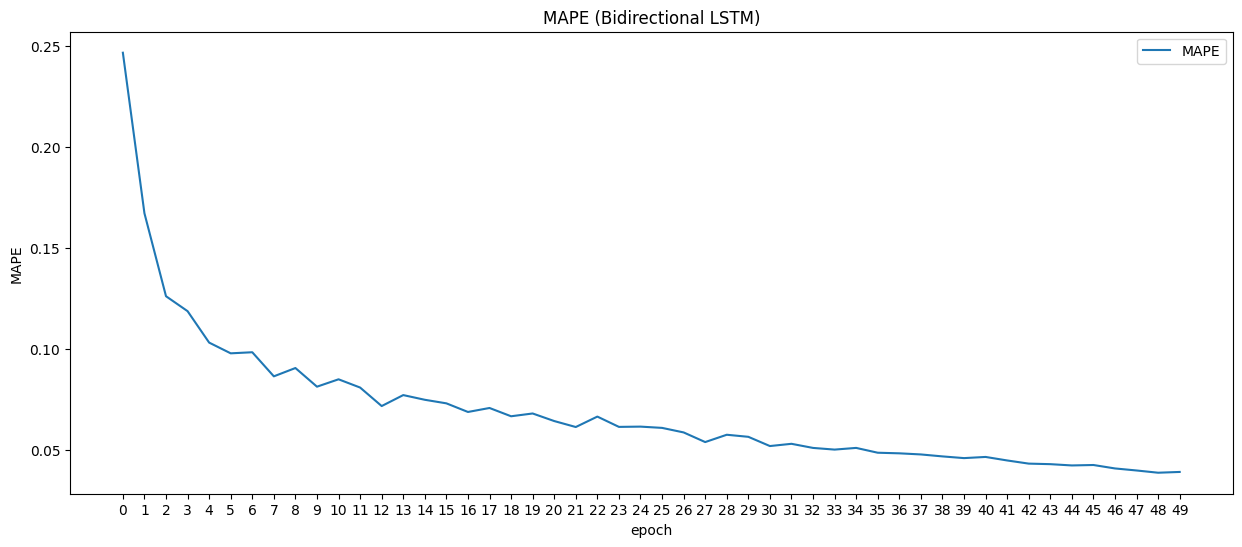

In [ ]:
# 학습 중 MAPE 추이 확인 (Bidirectional LSTM)

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,6))
plt.plot(train_hist[:50], label = 'MAPE')
plt.xlabel('epoch')
plt.xticks([i for i in range(0, 50)])
plt.title('MAPE (Bidirectional LSTM)')
plt.ylabel('MAPE')
plt.legend()
plt.show()

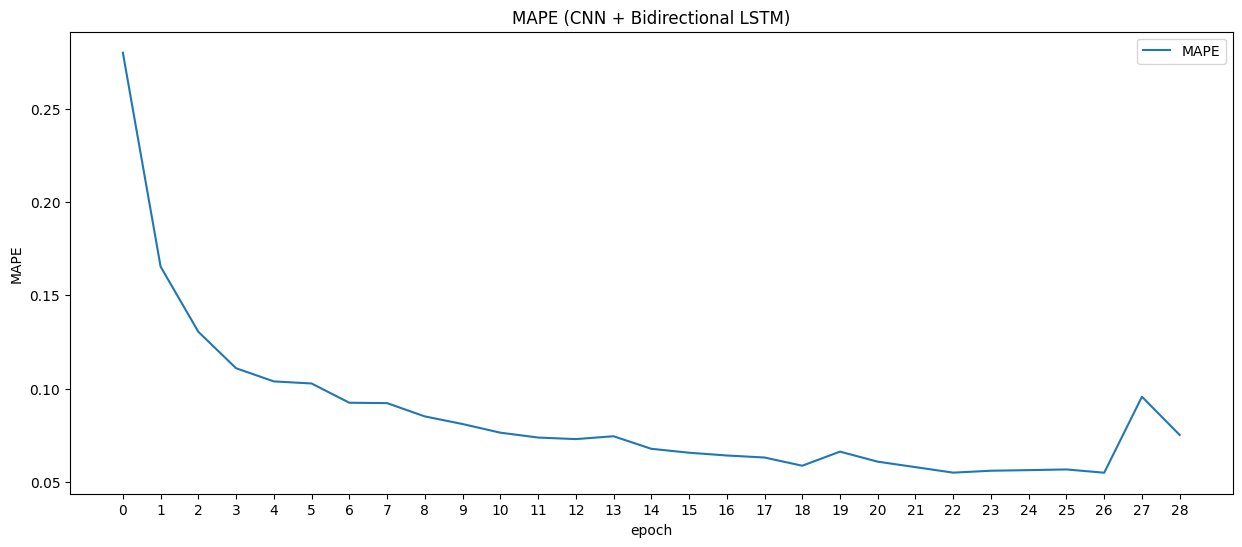

In [ ]:
# 학습 중 MAPE 추이 확인 (CNN + Bidirectional Model)

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,6))
plt.plot(cnn_bilstm_hist[:29], label = 'MAPE')
plt.xlabel('epoch')
plt.xticks([i for i in range(0, 29)])
plt.title('MAPE (CNN + Bidirectional LSTM)')
plt.ylabel('MAPE')
plt.legend()
plt.show()

In [ ]:
torch.save(model,'/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/modeling/모델링 결과/model_20230526_BILSTM.pth')

In [ ]:
torch.save(cnn_bilstm_model,'/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/modeling/모델링 결과/model_20230526_CNN-BILSTM.pth')

In [ ]:
# model_test (Bidirectional LSTM)

class CustomDatasetForTest(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1].reset_index(drop = True),
                                                               pd.DataFrame(scaler_for_Y.transform(np.array(target_df['load']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = (self.dataset_tensor.shape[0] - step_len - seq_len) // stride
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride
  
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :], self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

test_dataset = CustomDatasetForTest(test_df, 4, ss_1, ss_2, seq_len, step_len, stride)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, drop_last = True)

with torch.no_grad():
  bi_pred_list = []
  bi_true_list = []
  for X, y in test_dataloader:
    # 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)
    pred = model(X)
    bi_pred_list.append(pred)
    bi_true_list.append(y)

bi_MAPE_list = [torch.mean(torch.abs(pred - true)/true).item() for pred, true in zip(bi_pred_list, bi_true_list)]
print('평균 MAPE는 {}% 입니다'.format(round(sum(bi_MAPE_list)/len(bi_MAPE_list) * 100, 3)))

평균 MAPE는 9.659% 입니다


In [24]:
cnnbi_pred_list[0].cpu().detach().numpy()

array([[0.3471201 , 0.34251547, 0.33819813, 0.3311505 , 0.32649723,
        0.31741956, 0.31100085, 0.31090105, 0.31316116, 0.30494797,
        0.30369508, 0.29829633, 0.29859787, 0.29290164, 0.29165646,
        0.2869598 , 0.29110536, 0.29105774, 0.29018924, 0.28956538,
        0.28557998, 0.2863445 , 0.2842477 , 0.2859674 , 0.2838555 ,
        0.27640072, 0.28191996, 0.28135192, 0.2814356 , 0.28168717,
        0.2817312 , 0.27243388, 0.27920058, 0.27625287, 0.27783266,
        0.2800645 , 0.27585867, 0.27401   , 0.2707822 , 0.27756295,
        0.27740648, 0.27596945, 0.27505046, 0.27189395, 0.28235823,
        0.2785324 , 0.27984712, 0.28458986, 0.27956426, 0.2854265 ,
        0.28921106, 0.28971335, 0.29620057, 0.2916726 , 0.2980553 ,
        0.30093634, 0.30332318, 0.3047368 , 0.30794913, 0.3062051 ,
        0.3113105 , 0.31190208, 0.31223708, 0.3223345 , 0.32204935,
        0.32301196, 0.32876232, 0.33633438, 0.32972962, 0.3378115 ,
        0.34566435, 0.34838322]], dtype=float32)

In [17]:
ss_1.inverse_transform(cnnbi_pred_list[0].cpu())

ValueError: ignored

In [26]:
cnnbi_true_list[0].shape

torch.Size([1, 72])

In [ ]:
ss_2.inverse.transform(cnnbi_true_list[0])

In [38]:
# model_test (CNN + Bidirectional Model)

class CustomDatasetForTest(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1].reset_index(drop = True),
                                                               pd.DataFrame(scaler_for_Y.transform(np.array(target_df['load']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = (self.dataset_tensor.shape[0] - step_len - seq_len) // stride
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride
  
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :], self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

test_dataset = CustomDatasetForTest(test_df, 4, ss_1, ss_2, seq_len, step_len, stride)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, drop_last = True)

with torch.no_grad():
  cnnbi_pred_list = []
  cnnbi_true_list = []
  for X, y in test_dataloader:
    # 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)
    pred = cnn_bilstm_model(X)
    cnnbi_pred_list.append(ss_2.inverse_transform(pred.cpu().detach().numpy()))
    cnnbi_true_list.append(ss_2.inverse_transform(y.cpu().detach().numpy()))

cnnbi_MAPE_list = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnnbi_pred_list, cnnbi_true_list)]
print('평균 MAPE는 {}% 입니다'.format(round(sum(cnnbi_MAPE_list)/len(cnnbi_MAPE_list) * 100, 3)))

평균 MAPE는 1.879% 입니다


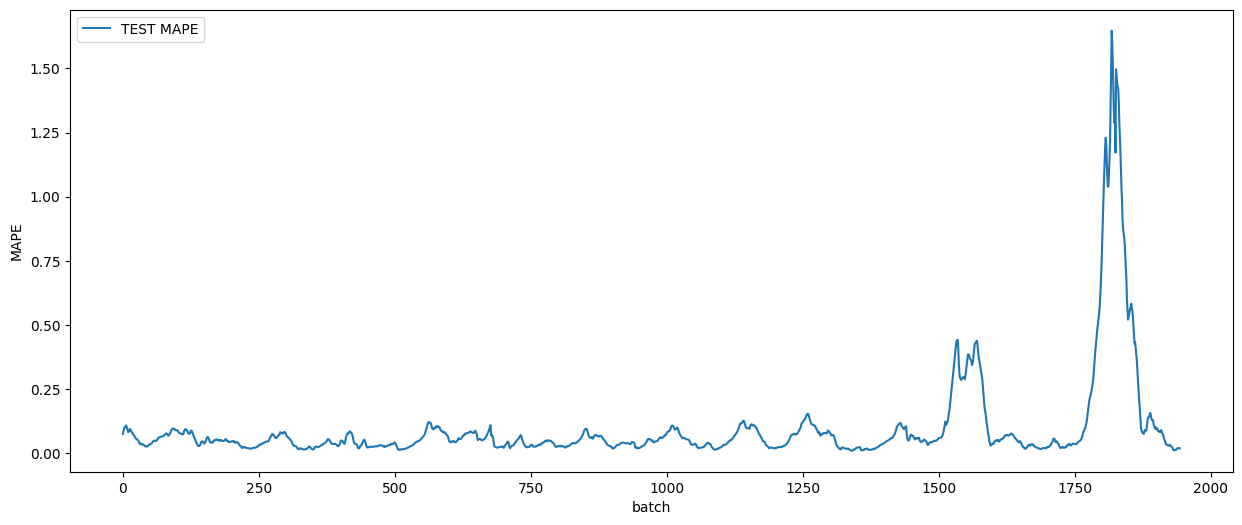

In [ ]:
# 학습 중 MAPE 추이 확인

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,6))
plt.plot(bi_MAPE_list, label = 'TEST MAPE')
plt.xlabel('batch')
plt.ylabel('MAPE')
plt.legend()
plt.show()

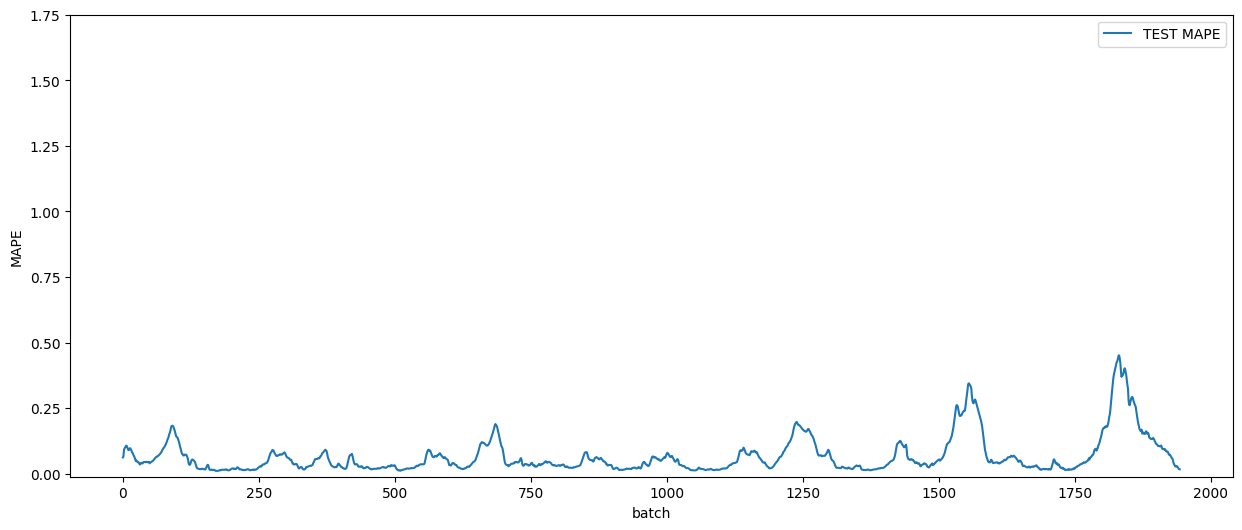

In [ ]:
# 학습 중 MAPE 추이 확인

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,6))
plt.plot(cnnbi_MAPE_list, label = 'TEST MAPE')
plt.xlabel('batch')
plt.ylabel('MAPE')
plt.yticks([i*0.25 for i in range(8)])
plt.legend()
plt.show()

### **금일 모델링에 대한 정리**

#### **모델 상세 - 양방향 LSTM**

* LSTM Layer의 개수 : 2개 (양방향 LSTM Layer)
* Hidden State의 개수 : 288개
* Sequence의 길이 : 2016개 (1일당 5분 간격 데이터 288개 * 일주일)
* Input Dimension(사용한 컬럼의 개수) : 58개

|분류|사용변수|
|---|---|
|기상인자 (3개) |최고기온, 최저기온, 평균일사량|
|달력정보 (54개) |요일특성(Dummy, 4개), 휴일유형 (Dummy, 14개), 월(Dummy, 12개), 시간(Dummy, 24개)|
|전력수요 (1개)|5분당 전력수요|

* 학습시간 : 약 4시간 40분 (50 epoch 학습)
* Train, Test 데이터를 미리 분리한 후, Train 데이터셋에만 Scaler를 Fit-Transform하여 학습하고 테스트 시에 Scaler로 Transform만 진행하여 Test 진행
* **TEST_MAPE : 9.66%**

#### **모델 상세 - 1D CNN + 양방향 LSTM**

* 합성곱 커널 사이즈 : 3
* 합성곱 필터의 개수 : 116
* LSTM Layer의 개수 : 2개 (양방향 LSTM Layer)
* Hidden State의 개수 : 288개
* Sequence의 길이 : 2016개 (1일당 5분 간격 데이터 288개 * 일주일)
* Input Dimension(사용한 컬럼의 개수) : 58개

|분류|사용변수|
|---|---|
|기상인자 (3개) |최고기온, 최저기온, 평균일사량|
|달력정보 (54개) |요일특성(Dummy, 4개), 휴일유형 (Dummy, 14개), 월(Dummy, 12개), 시간(Dummy, 24개)|
|전력수요 (1개)|5분당 전력수요|

* 학습시간 : 약 2시간 50분 (29 epoch 학습)
* Train, Test 데이터를 미리 분리한 후, Train 데이터셋에만 Scaler를 Fit-Transform하여 학습하고 테스트 시에 Scaler로 Transform만 진행하여 Test 진행
* **TEST_MAPE : 6.649%**

#### **발견한 점**

**CNN + 양방향 LSTM 모델이 양방향 LSTM, 일반 LSTM 보다 주중, 주말 예측 성능이 좋다.**

* 일반 LSTM의 TEST MAPE가 11.3%로 측정된 반면, 양방향 LSTM의 TEST_MAPE는 9.6%, 1D CNN + 양방향 LSTM의 TEST_MAPE는 6.65%입니다.. 3월 13일부터 3월 19일까지 연속적으로 계산된 MAPE를 LSTM과 양방향 LSTM으로 나누어 그래프로 나타내자면 다음과 같습니다. (위 : 일반 LSTM, 아래 : 양방향 LSTM)
* 양방향 LSTM의 경우, 평일 전력 수요 예측에서는 그래프의 변동폭이 줄어듬을 확인할 수 있었으나 주말 예측에서는 다소 악화된 부분도 확인할 수 있었습니다.
* 반면 CNN + 양방향 LSTM 복합모델은 주말 예측에서의 Loss를 상당 부분 축소하는 성능을 보였습니다.

**CNN + 양방향 LSTM의 MAPE**
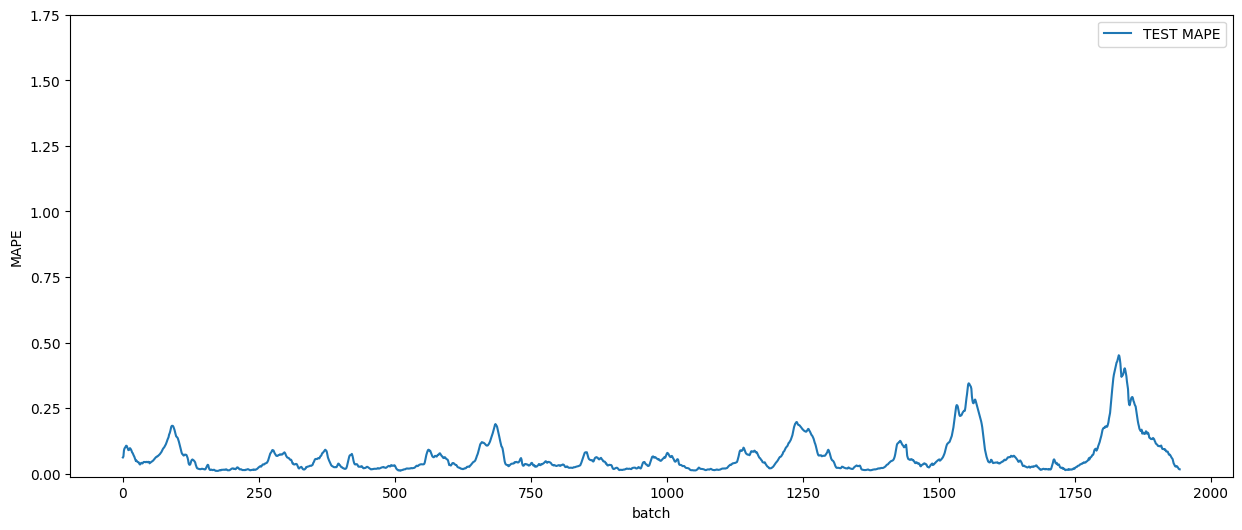

**양방향 LSTM의 MAPE**
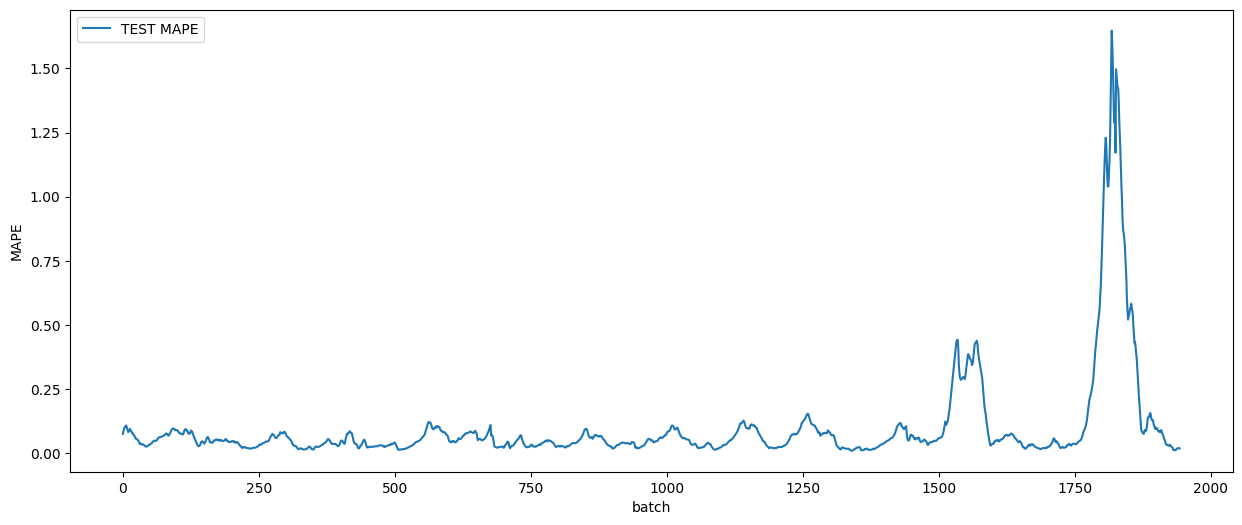

**일반 LSTM의 MAPE**
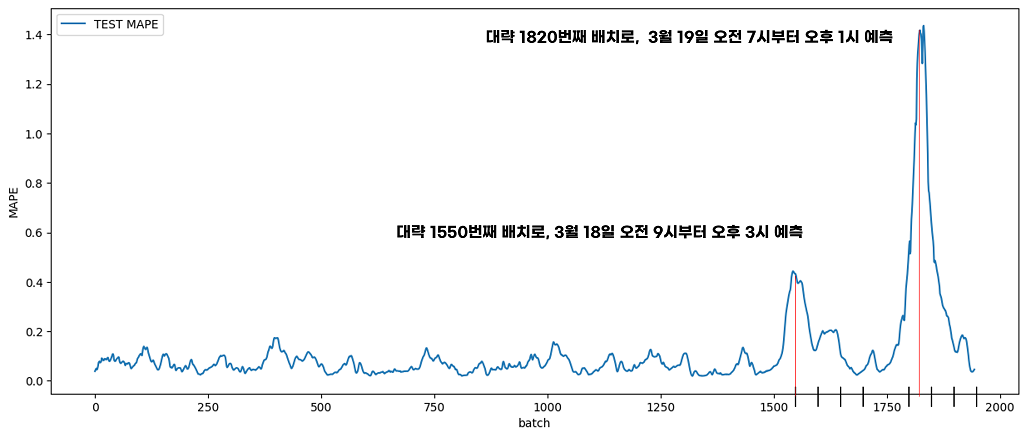

* 아래는 주중 / 주말의 예측과 실제값을 모델 유형에 따라 구분해보았습니다.

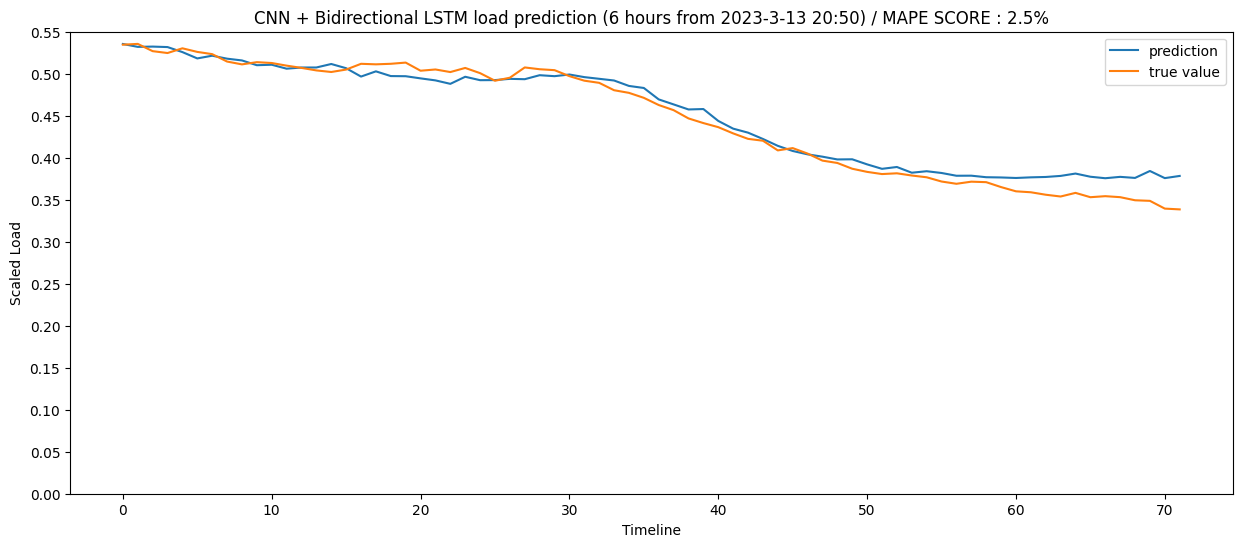

In [ ]:
fig = plt.figure(figsize = (15,6))
plt.plot(cnnbi_pred_list[250].cpu().numpy().tolist()[0], label = 'prediction')
plt.plot(cnnbi_true_list[250].cpu().numpy().tolist()[0], label = 'true value')
plt.title('CNN + Bidirectional LSTM load prediction (6 hours from 2023-3-13 20:50) / MAPE SCORE : {}%'.format(round(cnnbi_MAPE_list[250], 4)* 100))
plt.xlabel('Timeline')
plt.ylabel('Scaled Load')
plt.yticks([i*0.05 for i in range(12)])
plt.legend()
plt.show()

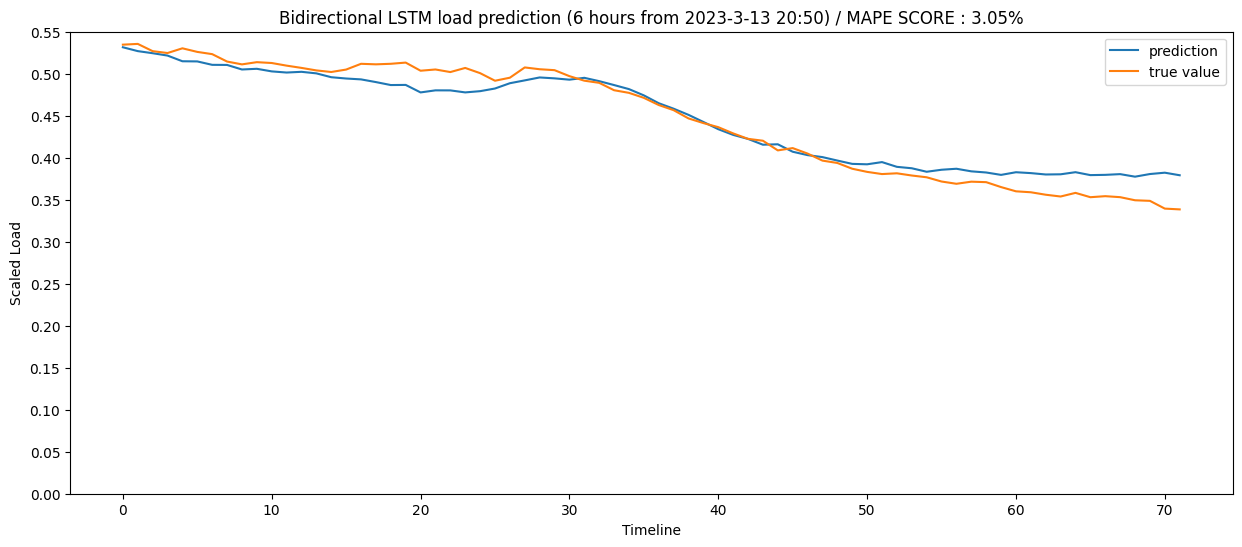

In [ ]:
fig = plt.figure(figsize = (15,6))
plt.plot(bi_pred_list[250].cpu().numpy().tolist()[0], label = 'prediction')
plt.plot(bi_true_list[250].cpu().numpy().tolist()[0], label = 'true value')
plt.title('Bidirectional LSTM load prediction (6 hours from 2023-3-13 20:50) / MAPE SCORE : {}%'.format(round(bi_MAPE_list[250], 4)* 100))
plt.xlabel('Timeline')
plt.ylabel('Scaled Load')
plt.yticks([i*0.05 for i in range(12)])
plt.legend()
plt.show()

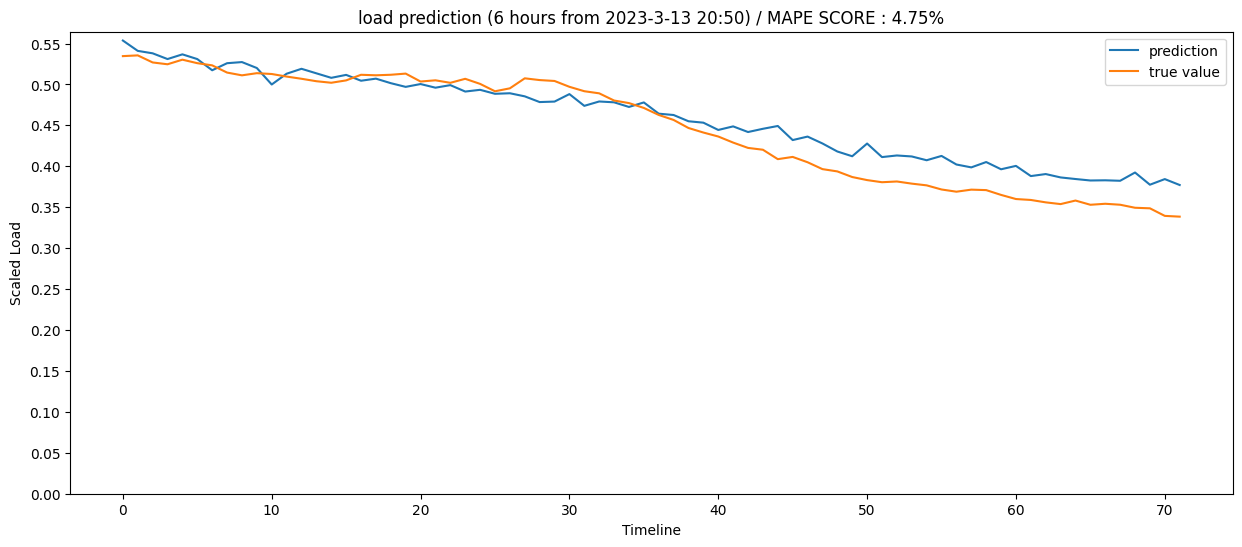

In [ ]:
fig = plt.figure(figsize = (15,6))
plt.plot(pred_list[250].cpu().numpy().tolist()[0], label = 'prediction')
plt.plot(true_list[250].cpu().numpy().tolist()[0], label = 'true value')
plt.title('load prediction (6 hours from 2023-3-13 20:50) / MAPE SCORE : {}%'.format(round(MAPE_list[250], 4)* 100))
plt.xlabel('Timeline')
plt.ylabel('Scaled Load')
plt.yticks([i*0.05 for i in range(12)])
plt.legend()
plt.show()

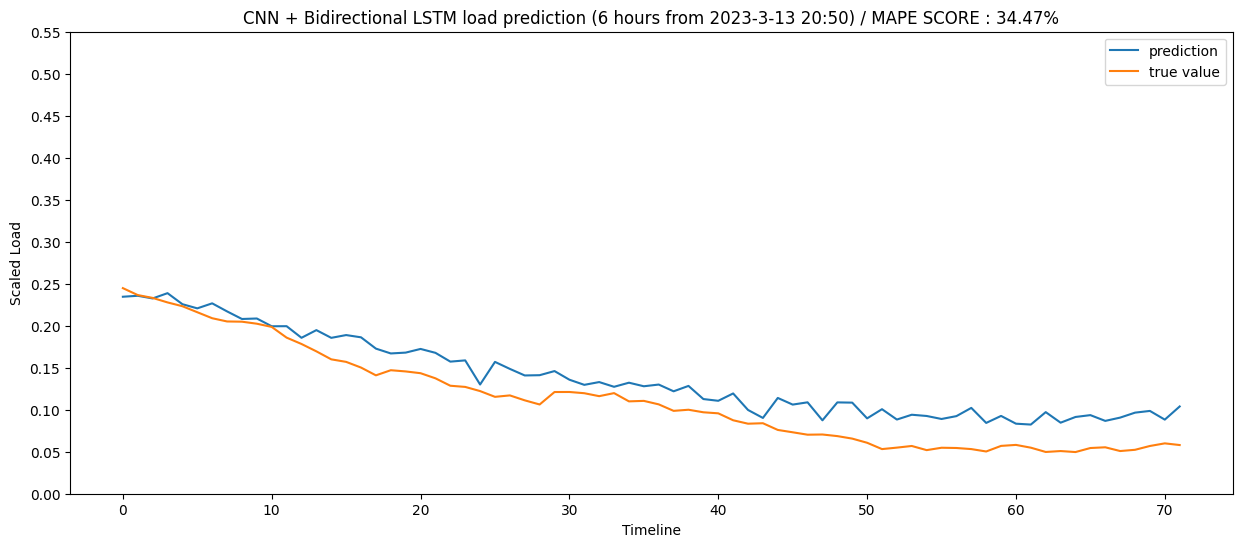

In [ ]:
fig = plt.figure(figsize = (15,6))
plt.plot(cnnbi_pred_list[1820].cpu().numpy().tolist()[0], label = 'prediction')
plt.plot(cnnbi_true_list[1820].cpu().numpy().tolist()[0], label = 'true value')
plt.title('CNN + Bidirectional LSTM load prediction (6 hours from 2023-3-13 20:50) / MAPE SCORE : {}%'.format(round(cnnbi_MAPE_list[1820], 4)* 100))
plt.xlabel('Timeline')
plt.ylabel('Scaled Load')
plt.yticks([i*0.05 for i in range(12)])
plt.legend()
plt.show()

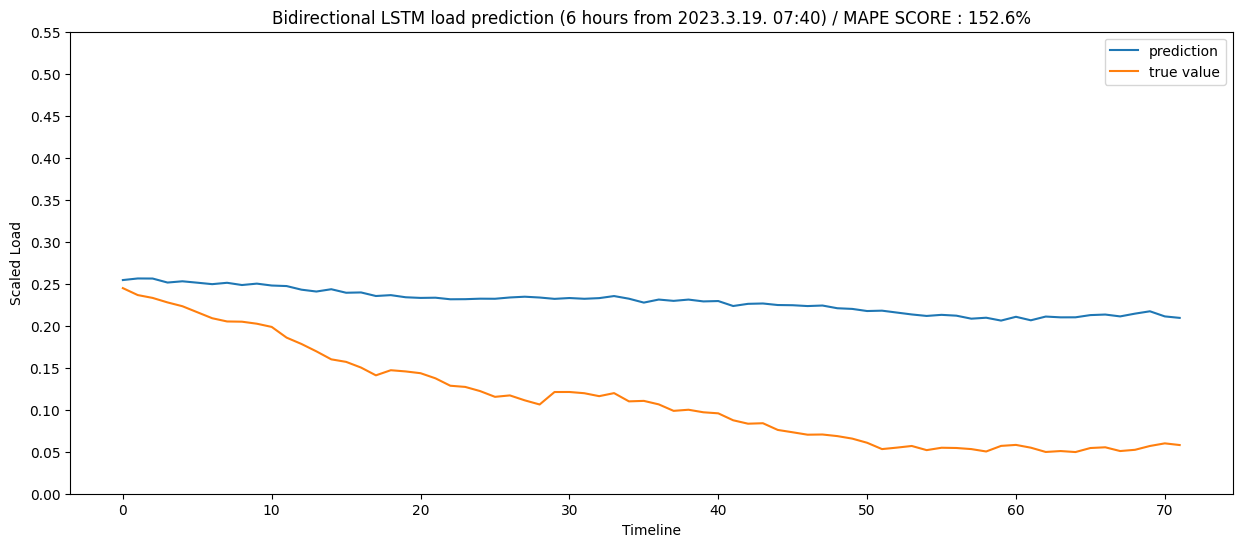

In [ ]:
fig = plt.figure(figsize = (15,6))
plt.plot(bi_pred_list[1820].cpu().numpy().tolist()[0], label = 'prediction')
plt.plot(bi_true_list[1820].cpu().numpy().tolist()[0], label = 'true value')
plt.title('Bidirectional LSTM load prediction (6 hours from 2023.3.19. 07:40) / MAPE SCORE : {}%'.format(round(bi_MAPE_list[1820], 4)* 100))
plt.xlabel('Timeline')
plt.ylabel('Scaled Load')
plt.yticks([i*0.05 for i in range(12)])
plt.legend()
plt.show()

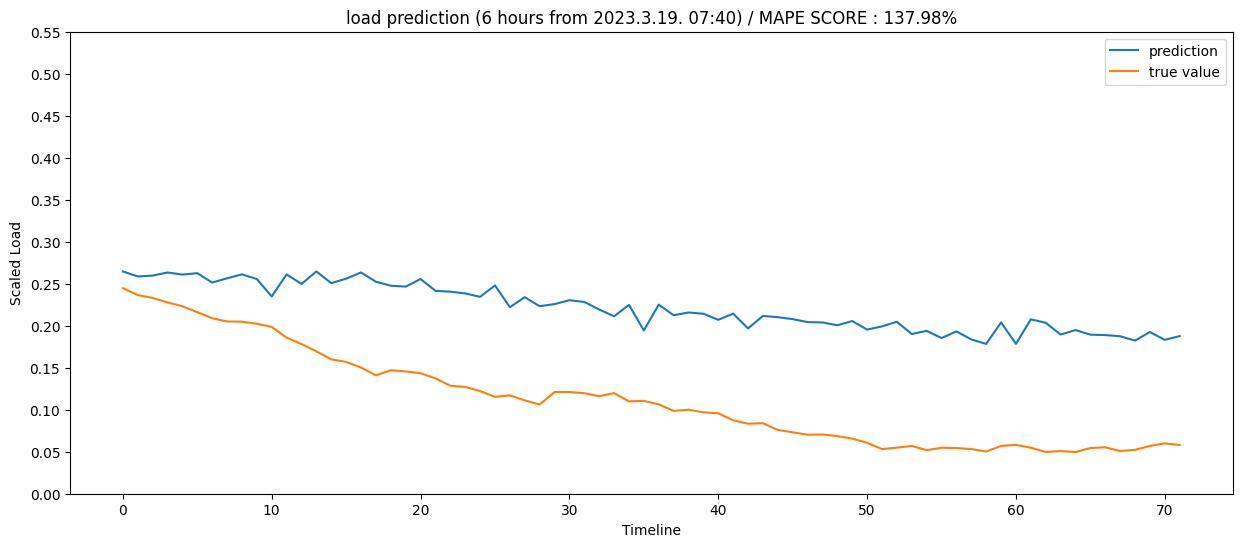

In [ ]:
fig = plt.figure(figsize = (15,6))
plt.plot(pred_list[1820].cpu().numpy().tolist()[0], label = 'prediction')
plt.plot(true_list[1820].cpu().numpy().tolist()[0], label = 'true value')
plt.title('load prediction (6 hours from 2023.3.19. 07:40) / MAPE SCORE : {}%'.format(round(MAPE_list[1820], 4)* 100))
plt.xlabel('Timeline')
plt.ylabel('Scaled Load')
plt.yticks([i*0.05 for i in range(12)])
plt.legend()
plt.show()